In [1]:
# import package

# model
import tensorflow as tf
from tensorflow import keras

# dataset and transformation
import io
import os
import cv2
import math
import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# display images
import matplotlib.pyplot as plt 
%matplotlib inline

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

# utils
import numpy as np
import pandas as pd
import time
import copy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconf

In [2]:
# GPU check
!nvidia-smi

Fri May  6 16:05:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# dataset download

!wget -O dataset.zip https://raw.githubusercontent.com/kitae0522/hangul-recognition/main/data/dataset.zip
!wget -O common-hangul-syllable.txt https://raw.githubusercontent.com/kitae0522/hangul-recognition/main/data/common-hangul-syllable.txt
!wget -O train.csv https://raw.githubusercontent.com/kitae0522/hangul-recognition/main/train.csv

!unzip -qq ./dataset.zip -d ./data

--2022-05-06 16:05:29--  https://raw.githubusercontent.com/kitae0522/hangul-recognition/main/data/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96897377 (92M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  92.41M   273MB/s    in 0.3s    

2022-05-06 16:05:30 (273 MB/s) - ‘dataset.zip’ saved [96897377/96897377]

--2022-05-06 16:05:30--  https://raw.githubusercontent.com/kitae0522/hangul-recognition/main/data/common-hangul-syllable.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

In [4]:
dataset = glob.glob(os.path.join('./data', '*.jpeg'))
print(len(dataset))

117500


In [5]:
with io.open('./common-hangul-syllable.txt', 'r', encoding='utf-8') as f:
    syllable_list = f.read().splitlines()
    
# encode dict
s_to_idx = {syllable:idx for idx, syllable in enumerate(syllable_list)}
idx_to_s = {idx:syllable for idx, syllable in enumerate(syllable_list)}
num_class = syllable_list.__len__()

df = pd.read_csv('./train.csv')

print(num_class, df.__len__())
df.head(5)

2350 117500


,path,label
0,./data/가_0.jpeg,가
1,./data/가_1.jpeg,가
2,./data/가_10.jpeg,가
3,./data/가_11.jpeg,가
4,./data/가_12.jpeg,가


In [6]:
xs = np.array(df['path'])
ys = np.array([s_to_idx[item] for item in df['label']])

train_x, valid_x, train_y, valid_y = train_test_split(xs, ys, test_size=0.2)
train_x, test_x, train_y, test_y = train_test_split(xs, ys, test_size=0.2)

train_x = np.array([cv2.imread(item, cv2.IMREAD_GRAYSCALE) for item in train_x]).reshape(train_x.shape[0], 48, 48, 1)
valid_x = np.array([cv2.imread(item, cv2.IMREAD_GRAYSCALE) for item in valid_x]).reshape(valid_x.shape[0], 48, 48, 1)
test_x = np.array([cv2.imread(item, cv2.IMREAD_GRAYSCALE) for item in test_x]).reshape(test_x.shape[0], 48, 48, 1)

In [7]:
print(train_x.shape, valid_x.shape, test_x.shape)
print(train_y.shape, valid_y.shape, test_y.shape)

(94000, 48, 48, 1) (23500, 48, 48, 1) (23500, 48, 48, 1)
(94000,) (23500,) (23500,)


In [8]:
def show_sample(image, label, sample_count=25):
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_cout = min(grid_count, len(image), len(label))
    plt.figure(figsize=(2*grid_count, 2*grid_count))

    for i in range(sample_count):
        plt.subplot(grid_count, grid_count, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image[i].reshape(48, 48), cmap=plt.cm.gray)
        plt.xlabel(idx_to_s[label[i]], fontsize=14)
    plt.show()

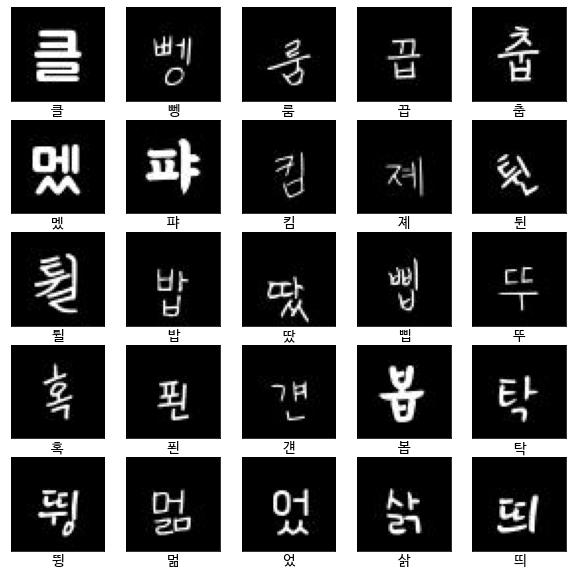

In [9]:
show_sample(train_x, train_y)

# VGG19 Architectures

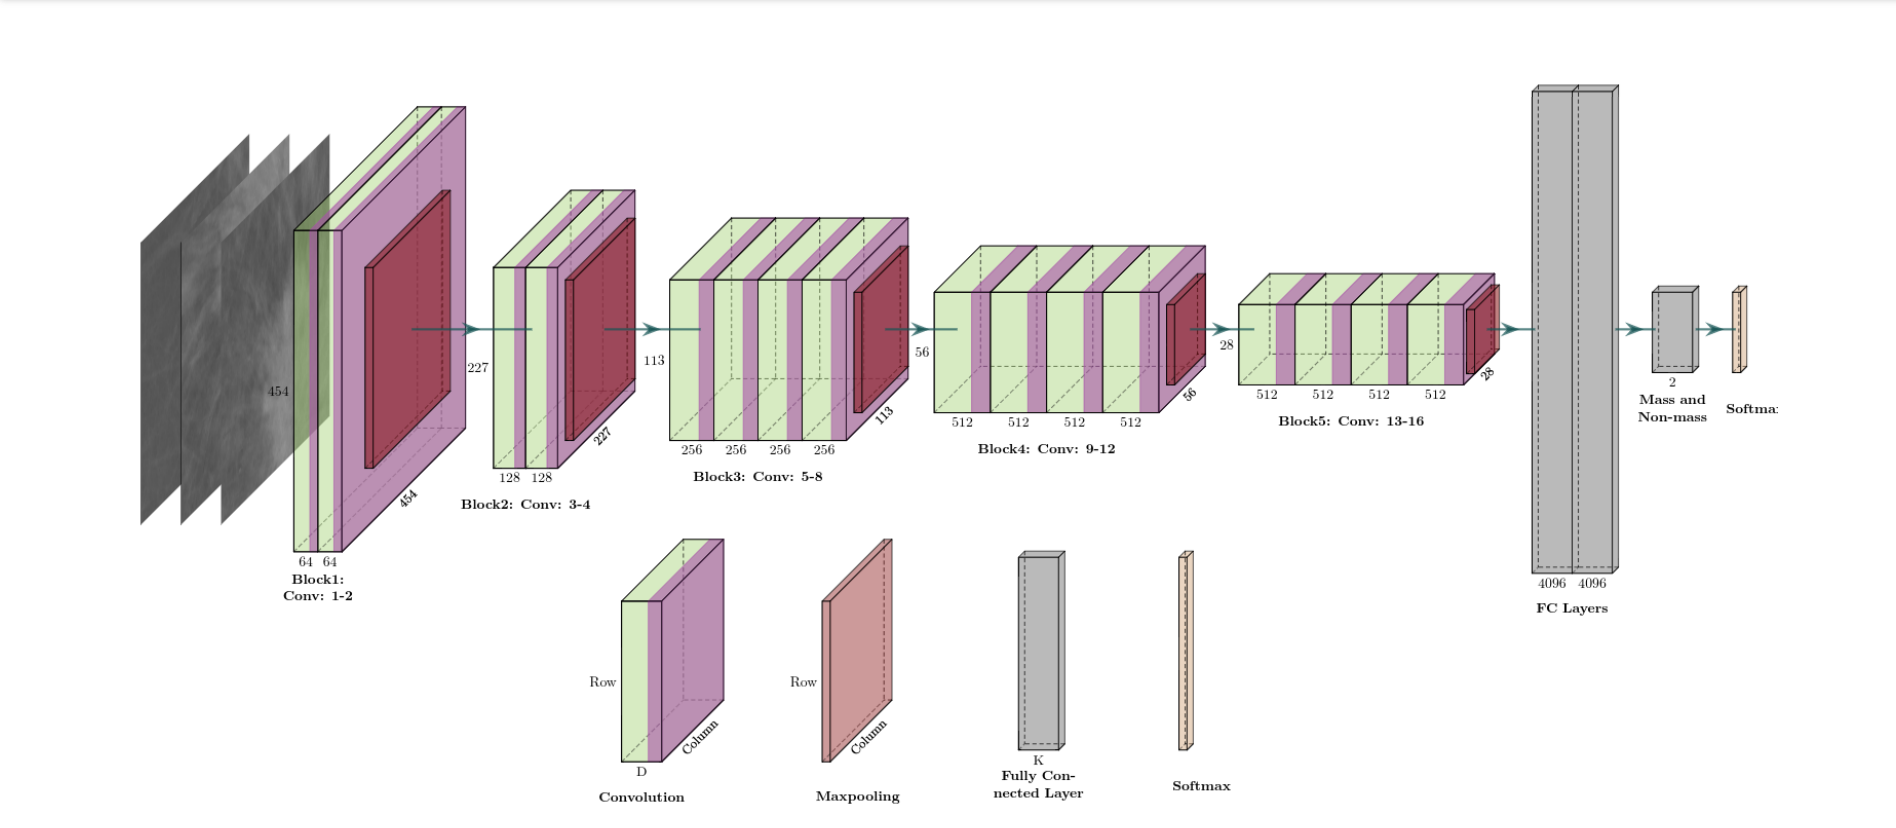

In [10]:
# 기존 vgg19 model에서 일부 layer을 수정했습니다.

X = keras.layers.Input(shape=[48, 48, 1])

# 1
H = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv2d_1_1')(X)
H = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv2d_1_2')(H)

# 2
H = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='maxpool2D_1')(H)
H = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv2d_2_1')(H)
H = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv2d_2_2')(H)

H = keras.layers.BatchNormalization()(H)
H = keras.layers.ReLU()(H)

# 3
H = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='maxpool2D_2')(H)
H = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv2d_3_1')(H)
H = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv2d_3_2')(H)
H = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv2d_3_3')(H)
H = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv2d_3_4')(H)

H = keras.layers.BatchNormalization()(H)
H = keras.layers.ReLU()(H)

# 4
H = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='maxpool2D_3')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_4_1')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_4_2')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_4_3')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_4_4')(H)

H = keras.layers.BatchNormalization()(H)
H = keras.layers.ReLU()(H)

# 5
H = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='maxpool2D_4')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_5_1')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_5_2')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_5_3')(H)
H = keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv2d_5_4')(H)

H = keras.layers.BatchNormalization()(H)
H = keras.layers.ReLU()(H)

# 6
H = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='maxpool2D_5')(H)
H = keras.layers.Flatten()(H)
H = keras.layers.Dense(units=2048, activation='relu')(H)
H = keras.layers.Dense(units=2048, activation='relu')(H)
Y = keras.layers.Dense(units=num_class, activation='softmax')(H)

model = keras.models.Model(X, Y)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1_1 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 conv2d_1_2 (Conv2D)         (None, 48, 48, 64)        36928     
                                                                 
 maxpool2D_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 conv2d_2_1 (Conv2D)         (None, 24, 24, 128)       73856     
                                                                 
 conv2d_2_2 (Conv2D)         (None, 24, 24, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 128)      512   

In [11]:
# val_loss가 제일 적었던 모델을 저장했습니다.

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)

start_time = time.time()

history = model.fit(
    train_x, train_y, validation_data=(valid_x, valid_y),
    epochs=50, batch_size=128, callbacks=callbacks
)

print(f'{time.time() - start_time}초 동안 학습함.')

Epoch 1/50
735/735 [==============================] - 112s 145ms/step - loss: 7.7643 - acc: 7.2340e-04 - val_loss: 7.6462 - val_acc: 0.0016
Epoch 2/50
735/735 [==============================] - 104s 142ms/step - loss: 6.9253 - acc: 0.0062 - val_loss: 6.0426 - val_acc: 0.0193
Epoch 3/50
735/735 [==============================] - 106s 145ms/step - loss: 4.9005 - acc: 0.0724 - val_loss: 3.9303 - val_acc: 0.1476
Epoch 4/50
735/735 [==============================] - 106s 144ms/step - loss: 3.0841 - acc: 0.2764 - val_loss: 2.4076 - val_acc: 0.3910
Epoch 5/50
735/735 [==============================] - 106s 144ms/step - loss: 1.9372 - acc: 0.5072 - val_loss: 1.5541 - val_acc: 0.6157
Epoch 6/50
735/735 [==============================] - 105s 143ms/step - loss: 1.2464 - acc: 0.6891 - val_loss: 1.0532 - val_acc: 0.7361
Epoch 7/50
735/735 [==============================] - 106s 144ms/step - loss: 0.8151 - acc: 0.8110 - val_loss: 0.6943 - val_acc: 0.8433
Epoch 8/50
735/735 [========================

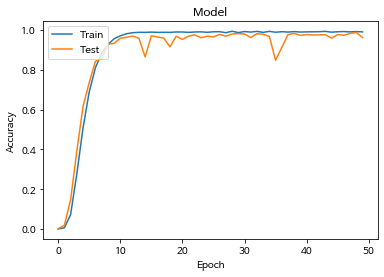

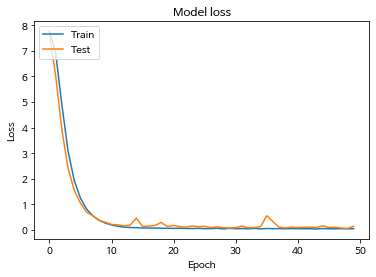

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
model = keras.models.load_model('model.h5')
pred = model.predict(test_x)

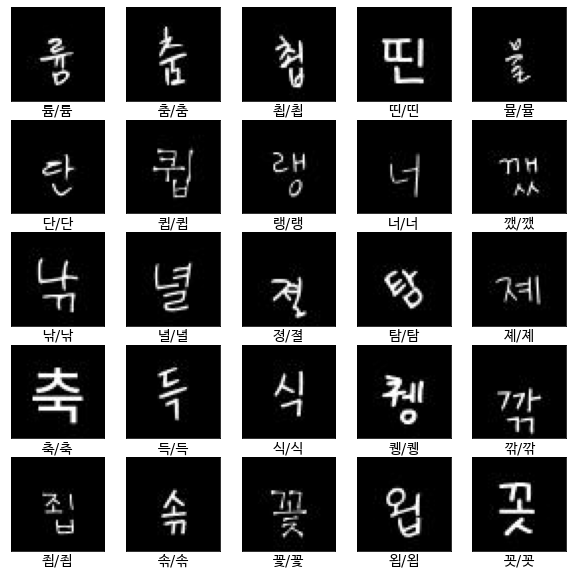

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_x.reshape(-1, 48, 48)[i], cmap=plt.cm.gray)
    plt.xlabel(f'{idx_to_s[np.argmax(pred[i])]}/{idx_to_s[test_y[i]]}', fontsize=14)
plt.show()

# 왼쪽이 예측 결과, 오른쪽이 실제 정답

In [ ]:
"""
https://github.com/ndb796/CNN-based-Celebrity-Classification-AI-Service-Using-Transfer-Learning

Ngrok 호스팅하는 부분은 위에 코드를 참고했습니다.
"""

!pip install flask-ngrok

from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request

app = Flask(__name__)
model = keras.models.load_model('model.h5')

@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()

        encoded_img = np.fromstring(img_bytes, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_GRAYSCALE).reshape(1, 48, 48, 1)
        pred = idx_to_s[model.predict(img).argmax()]

        print('예측 결과:', {'pred': pred})
        plt.title(f'예측 결과: {pred}', fontsize=16)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img.reshape(48, 48), cmap=plt.cm.gray)
        plt.show()

        return jsonify({'pred': pred})

run_with_ngrok(app)
app.run()